In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline

# load data

In [2]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})

In [3]:
df = df.rename(columns={df.columns[0]: 'id'})
df = df[df["Community"] != "-1"]
df.head()

,id,Community,V27,V28,V29,V30,V31,V32,V33
0,0,Comm.FOSSASIA,4,4,4,5,1,1,1
1,1,Comm.FOSSASIA,5,5,5,5,1,1,1
2,2,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
3,3,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1
4,4,Comm.FOSSASIA,-1,-1,-1,-1,-1,-1,-1


In [4]:
df.iloc[:,1:].describe()

,V27,V28,V29,V30,V31,V32,V33
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,1.492754,1.533333,1.440580,1.623188,0.504348,0.344928,0.678261
std,2.648075,2.682776,2.605357,2.763453,1.689781,1.542003,1.864047
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,4.000000,4.000000,4.000000,5.000000,2.000000,1.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


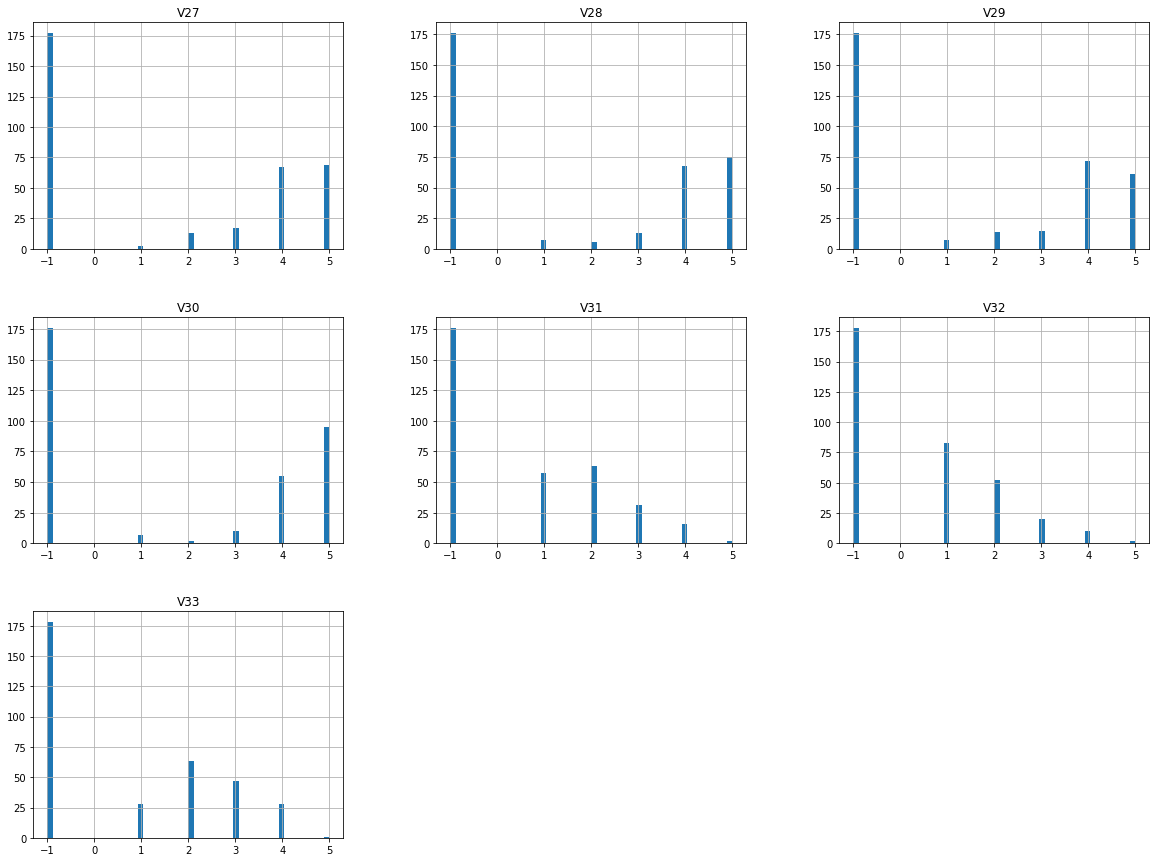

In [5]:
df.hist(column=df.columns[1:], bins=50, figsize=(20,15))
plt.show()

In [34]:
# V27 = df[df.Community == 'Comm.FOSSASIA'].V27.to_numpy()
def isPositive(i):
    return int (i <= 3)

def removeNoAnswer(lst):
    return [i for i in lst if i!=-1]
#    return lst[np.where(lst != -1)]

data = []
for com in df.Community.unique():
    V27 = removeNoAnswer(df[df.Community == com].V27.to_numpy())
    V28 = removeNoAnswer(df[df.Community == com].V28.to_numpy())
    V29 = removeNoAnswer(df[df.Community == com].V29.to_numpy())
    V30 = removeNoAnswer(df[df.Community == com].V30.to_numpy())
    V31 = removeNoAnswer(df[df.Community == com].V31.to_numpy())
    V32 = removeNoAnswer(df[df.Community == com].V32.to_numpy())
    V33 = removeNoAnswer(df[df.Community == com].V33.to_numpy())
    columns  = [V27, V28, V29, V30, V31, V32, V33]
    positive = [[int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    all = (com, columns, positive, N, μ, σ)
    data.append(all)

In [7]:
# def standardize(data, m, sd):
#     return (data-m)/sd
# all_z = []
# for i in range(len(answers)):
#     lst=[]
#     for com in range(len(answers[i])):
#         z=standardize(answers[i][com], μ[i][com], σ[i][com])
#         lst.append(z)
#     all_z.append(lst)


In [35]:
def getrelevant(com, dataIndex):
    (com, columns, positive, N, μ, σ)=next(filter(lambda lst : lst[0]==com, data))
    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex])

(com_coala, z_coala, positive_coala, N_coala, μ_coala, σ_coala)=getrelevant("Comm.Coala", 6)
(com_linux, z_linux, positive_linux, N_linux, μ_linux, σ_linux)=getrelevant("Comm.Linux_Kernel", 6)

print("z: ",z_coala,z_linux)
print("p: ",positive_coala,positive_linux)
print("N: ",N_coala,N_linux)
print("μ: ",μ_coala,μ_linux)
print("σ: ",σ_coala,σ_linux)

z:  [2, 1, 2, 2, 1, 2, 2] [2, 4, 4, 3, 3, 1, 2, 3, 2, 3, 3, 4, 3, 4, 2, 2, 3, 4]
p:  [1, 1, 1, 1, 1, 1, 1] [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
N:  7 18
μ:  1.7142857142857142 2.888888888888889
σ:  0.45175395145262565 0.8748897637790901


In [45]:
def makeModel(observed_coala, observed_linux):
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[μ_coala, μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[σ_coala, σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν,mu=μ[0],sd=σ[0],observed=observed_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν,mu=μ[1],sd=σ[1],observed=observed_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[1]-μ[0])
        diff_σ   = pm.Deterministic('diff_σ', σ[1]-σ[0])
    return model_h1
        
model_h1_pure    =makeModel(z_coala, z_linux)
model_h1_positive=makeModel(positive_coala, positive_linux)

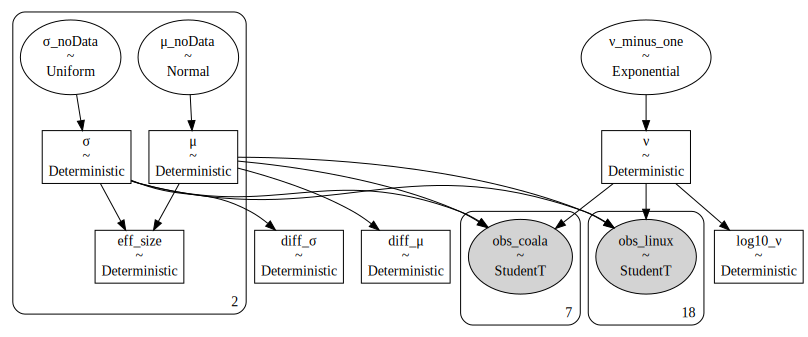

In [46]:
pm.model_to_graphviz(model_h1_pure)

In [48]:
resamble=True
def getTrace(folderName, model_h1):
    with model_h1:
        if (resamble):
            trace_h1=pm.sample(10000, chains=4, cores=1, step=pm.NUTS())
            pm.save_trace(trace_h1, folderName, overwrite=True)
    trace_h1  = pm.load_trace(folderName,     model=model_h1)
    trace_h1_inferencedata = az.from_pymc3(trace_h1,model=model_h1)
    return (trace_h1, trace_h1_inferencedata)
(trace_h1_pure, trace_h1_inferencedata_pure) = getTrace("h1_pure.trace", model_h1_pure)
(trace_h1_positive, trace_h1_inferencedata_positive) = getTrace("h1_positive.trace", model_h1_positive)

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 55 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\pymc3\sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Sequential sampling (4 chains in 1 job)
NUTS: [ν_minus_one, σ_noData, μ_noData]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 141 seconds.
The acceptance probability does not match the target. It is 0.9891613535143365, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9526075359153375, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841549236219974, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
az.summary(trace_h1_pure)

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.012,0.148,0.742,1.293,0.001,0.001,25501.0,20402.0,1.0
μ_noData[1],1.003,0.082,0.843,1.154,0.001,0.000,26385.0,23303.0,1.0
μ[0],1.734,0.253,1.272,2.217,0.002,0.001,25501.0,20402.0,1.0
μ[1],2.897,0.236,2.434,3.333,0.001,0.001,26385.0,23303.0,1.0
σ_noData[0],1.356,0.595,0.587,2.422,0.005,0.003,17785.0,15336.0,1.0
σ_noData[1],1.080,0.215,0.714,1.487,0.001,0.001,22068.0,22334.0,1.0
σ[0],0.613,0.269,0.265,1.094,0.002,0.002,17785.0,15336.0,1.0
σ[1],0.945,0.188,0.625,1.301,0.001,0.001,22068.0,22334.0,1.0
ν_minus_one,35.467,30.430,0.368,91.306,0.171,0.124,22747.0,13645.0,1.0
ν,36.467,30.430,1.368,92.306,0.171,0.124,22747.0,13645.0,1.0


In [49]:
az.summary(trace_h1_positive)

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],0.583,0.000,0.583,0.584,0.000,0.000,26572.0,19907.0,1.0
μ_noData[1],0.346,0.000,0.346,0.346,0.000,0.000,29161.0,23969.0,1.0
μ[0],1.000,0.000,1.000,1.000,0.000,0.000,26572.0,19907.0,1.0
μ[1],1.000,0.000,1.000,1.000,0.000,0.000,29161.0,23969.0,1.0
σ_noData[0],0.001,0.000,0.001,0.002,0.000,0.000,27032.0,18852.0,1.0
σ_noData[1],0.001,0.000,0.001,0.002,0.000,0.000,26551.0,16227.0,1.0
σ[0],0.001,0.000,0.000,0.001,0.000,0.000,27032.0,18852.0,1.0
σ[1],0.001,0.000,0.001,0.001,0.000,0.000,26551.0,16227.0,1.0
ν_minus_one,0.041,0.040,0.000,0.114,0.000,0.000,28230.0,16835.0,1.0
ν,1.041,0.040,1.000,1.114,0.000,0.000,28230.0,16835.0,1.0


In [52]:
var_names=['log10_ν', 'μ', 'σ', 'diff_μ', 'diff_σ']
def plotMethod1(trace_h1_inferencedata):
    #todo: rope=
    az.plot_posterior(trace_h1_inferencedata, var_names=var_names,  kind='hist', figsize=(10,5));
def plotMethod2(traceh1):
    az.plot_trace(az.from_pymc3(trace_h1,model=model_h1), var_names=var_names);

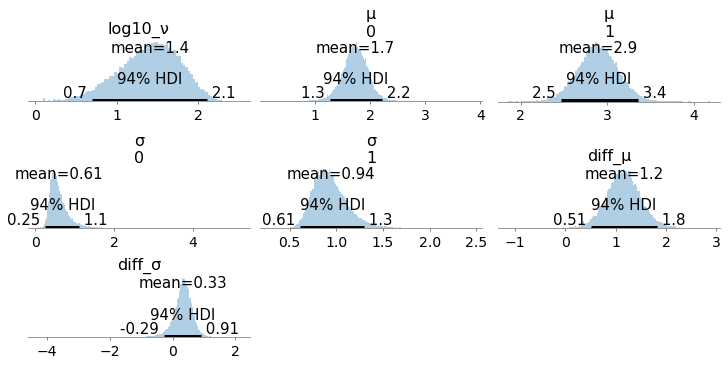

In [53]:
plotMethod1(trace_h1_inferencedata_pure)

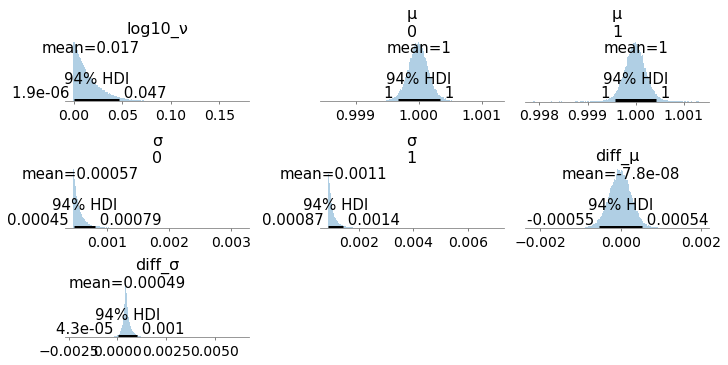

In [54]:
plotMethod1(trace_h1_inferencedata_positive)

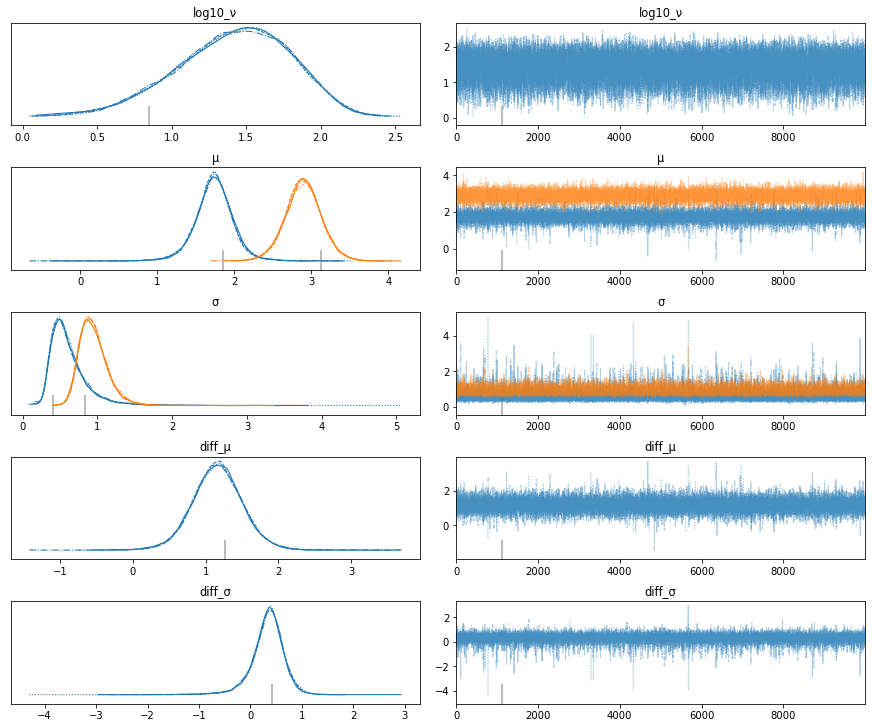

In [55]:
plotMethod2(trace_h1_pure)

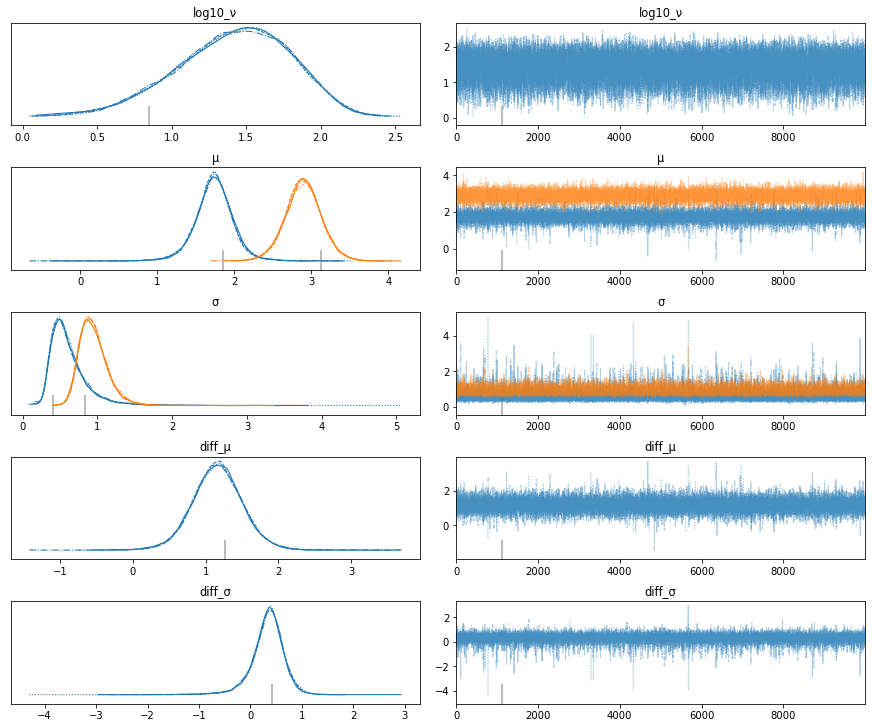

In [56]:
plotMethod2(trace_h1_positive)